In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
words=open('names.txt','r').read().splitlines()
char=sorted(set(''.join(words))) 
stoi={s:(i+1) for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)


In [8]:
block_size=8
def build_dataset(words):
    x,y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            context=context[1:]+[ix]
    xs=torch.tensor(x)    
    ys=torch.tensor(y)
    return xs,ys

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_dev,y_dev=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])

In [9]:
for x,y in zip(x_train[:20],y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x),'\t',itos[y.item()])

........ 	 e
.......e 	 b
......eb 	 r
.....ebr 	 i
....ebri 	 m
...ebrim 	 a
..ebrima 	 .
........ 	 h
.......h 	 i
......hi 	 l
.....hil 	 t
....hilt 	 o
...hilto 	 n
..hilton 	 .
........ 	 j
.......j 	 h
......jh 	 e
.....jhe 	 n
....jhen 	 e
...jhene 	 .


In [14]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.zeros(fan_out) if bias else None
        
    def __call__(self,x):
        self.out=x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
        
    def parameters(self):
        return [self.weight]+([] if self.bias is None else [self.bias])
#--------------------------------------------------------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
      
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):

    if self.training:
      if x.ndim==2:
          dim=0
      elif x.ndim==3:
          dim=(0,1)
      xmean = x.mean(dim, keepdim=True) 
      xvar = x.var(dim, keepdim=True) 
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) 
      
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

#--------------------------------------------------------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
      
  def parameters(self):
    return []
#--------------------------------------------------------------------------------------------------------------------------------------------      
class Embedding:
    def __init__(self,num_emb,emb_dim):
        self.weight=torch.randn(num_emb,emb_dim,generator=g)

    def __call__(self,index):
        self.out=self.weight[index]
        return self.out

    def parameters(self):
        return [self.weight]

#--------------------------------------------------------------------------------------------------------------------------------------------
class FlattenC:
    def __init__(self,n):
        self.n=n
        
    def __call__(self,x):
        B,T,C=x.shape
        x=x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            x=x.squeeze(1)
        self.out=x
        return self.out

    def parameters(self):
        return []
#----------------------------------------------------------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self,layers):
        self.layers=layers

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        self.out=x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
#----------------------------------------------------------------------------------------------------------------------------------------------      
n_emb=24
n_hidden=128
vocab_size=len(stoi)

g=torch.Generator().manual_seed(2147483647)

model=Sequential([
    Embedding(vocab_size,n_emb),
    FlattenC(2),
    Linear(2*n_emb,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    FlattenC(2),    
    Linear(2*n_hidden,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    FlattenC(2),    
    Linear(2*n_hidden,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(           n_hidden,vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight*=0.1
    # for layer in layers[:-1]:
    #     if isinstance(layer,Linear):
    #         layer.weight*=1 #5/3


parameters=model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

76579


In [16]:
max_steps=200000
batch_size=32
n=batch_size
lossi,lri=[],[]
for i in range(max_steps):

    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    xs,ys=x_train[ix],y_train[ix]
    
    logits=model(xs)
    loss=F.cross_entropy(logits,ys)
    
    for p in parameters:
        p.grad=None
    loss.backward()

    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    lossi.append(loss.log10().item())
    lri.append(i)

    if i%10000==0:
         print(f'{i}/{100000}\t{loss}')
    # break

0/100000	3.2639403343200684
10000/100000	2.234916925430298
20000/100000	2.0545263290405273
30000/100000	2.1416735649108887
40000/100000	1.88023042678833
50000/100000	1.982135534286499
60000/100000	2.056563377380371
70000/100000	1.8419013023376465
80000/100000	1.3891226053237915
90000/100000	2.00595760345459
100000/100000	1.937696099281311
110000/100000	1.7891194820404053
120000/100000	2.410231590270996
130000/100000	1.6866563558578491
140000/100000	1.3954452276229858
150000/100000	1.609774112701416
160000/100000	1.4308397769927979
170000/100000	1.7757346630096436
180000/100000	1.3888370990753174
190000/100000	1.7857197523117065


# Error in batch normalization
model.layers[3].running_mean.shape
output is [1,4,68]
which is not true because in 3d tensor batch size will be (32,4)
so when we do batch norm, it should calculate mean across (0,1 ) dim 
so we use torch .mean to calculate across (0,1 ) such that 
model.layers[3].running_mean.shape
is

In [125]:
model.layers[3].running_mean.shape


torch.Size([1, 1, 128])

In [126]:
for layer in model.layers:
    print(layer.__class__.__name__,'\t',tuple(layer.out.shape))

Embedding 	 (32, 8, 24)
FlattenC 	 (32, 4, 48)
Linear 	 (32, 4, 128)
BatchNorm1d 	 (32, 4, 128)
Tanh 	 (32, 4, 128)
FlattenC 	 (32, 2, 256)
Linear 	 (32, 2, 128)
BatchNorm1d 	 (32, 2, 128)
Tanh 	 (32, 2, 128)
FlattenC 	 (32, 256)
Linear 	 (32, 128)
BatchNorm1d 	 (32, 128)
Tanh 	 (32, 128)
Linear 	 (32, 27)


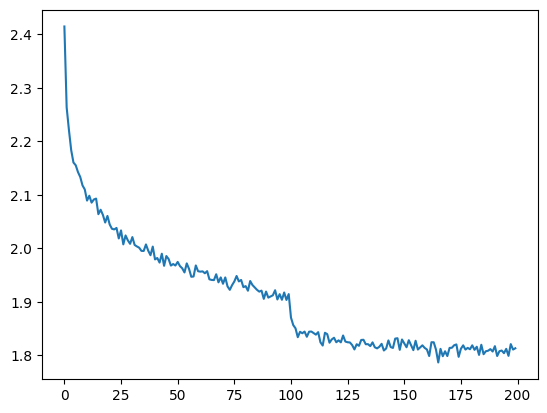

In [127]:
plt.plot(10**(torch.tensor(lossi).view(-1,1000).mean(1)))
# torch.tensor(lossi).view(-1,1000).mean(1).shape
# plt.plot(lossi)

In [128]:
for layer in model.layers:
    layer.training=False

In [141]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    xb,yb = {
        'train': (x_train, y_train),
        'val': (x_dev, y_dev),
        'test': (x_test, y_test),
      }[split]
    logits=model(xb)
    loss = F.cross_entropy(logits, yb)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7842748165130615
val 1.9782551527023315


In [120]:
# before implementation of wavenet and 
    # block size =3 (i.e MLP)
        #train 2.0660288333892822
        # val 2.11008620262146
    # block size =8 (i.e MLP)
         # train 1.918,
         # val 2.027
# after implementation of wavenet
        #train 1.8025965690612793
        # val 1.9713914394378662
#in wavenet we added layers so no of parameters increased but when we keep n_hidden 68 total parameters roughly becomes same as the previous
#model i.e. MLP
        # train 1.9557833671569824
        # val 2.023848533630371
    #conclusion on keeping same no of parameters in MlP and in wavenet porformance is not highly optimized

In [147]:
block_size=8
for i in range(10):
    context=[0]*block_size
    out=[]
    while True:
        logits=model(torch.tensor([context]))
        prob=F.softmax(logits,dim=1)
        ix=torch.multinomial(prob,num_samples=1,).item()
        out.append(itos[ix])
        context=context[1:]+[ix]
        if ix==0:
            break
    print(''.join(out))
    

kayla.
slant.
carius.
kalani.
lexande.
kayron.
jalys.
rilinger.
phoenix.
emmauri.
